# Assignment 3: Hidden Markov Models

---

## Task 1) Isolated Word Recognition

In this assignment, we'll be revising word recognition, this time using Hidden Markov Models (HMM).
As with [assignment 1](https://github.com/seqlrn/assignments/tree/master/1-dynamic-programming), we'll be using the [free spoken digits](https://github.com/Jakobovski/free-spoken-digit-dataset) dataset.
We will be using the [`pandas`](https://pandas.pydata.org/docs/) library for data handling and [`hmmlearn`](https://hmmlearn.readthedocs.io/en/latest/index.html) library for HMMs which depends on `numpy`.
Install the `pandas` and `hmmlearn` packages in your working environment and get familiar with these modules.


### Data

Download Zohar Jackson's [free spoken digit](https://github.com/Jakobovski/free-spoken-digit-dataset) dataset.
There's no need to clone, feel free to use a revision, like [v1.0.10](https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/tags/v1.0.10.tar.gz).
The file naming convention is `{digitLabel}_{speakerName}_{index}.wav`.

### Basic Setup

As you can learn from the [tutorial](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#), `hmmlearn` provides us with the base implementation of Hidden Markov Models; we'll be using the `hmm.GaussianHMM`, which implements HMMs with a single Gaussian emission probability per state.
For a starter, build a basic isolated word recognizer that uses a separate model for each digit.

*In this Jupyter Notebook, we will provide the steps to solve this task and give hints via functions & comments. However, code modifications (e.g., function naming, arguments) and implementation of additional helper functions & classes are allowed. The code aims to help you get started.*

---

In [1]:
# Dependencies
import os
import librosa
import numpy as np
import pandas as pd
from hmmlearn import hmm

### Prepare the Data

1.1 To facilitate the selection of samples for speakers and digits, consider how you can store the data within a `pandas.DataFrame`.

1.2 Compute the MFCC features for the complete data set (3000 recordings; use `n_mfcc=13`).

1.3 Apply per-speaker feature normalization (e.g., standardization).

In [2]:
NUM_SAMPLES = 50 # recordings per speaker & digit
DIGITS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
SPEAKERS = ["george", "jackson", "lucas", "nicolas", "theo", "yweweler"]

In [13]:
### Notice: a good default value is 25ms for FFT window and 10ms for hop length
### Notice: be careful as librosa takes the number of samples as input!        

import itertools
from sklearn.preprocessing import StandardScaler

def compute_features(file):
    """Computes the features for a recording file."""
    ### YOUR CODE HERE
    
    y, sr = librosa.load(file)
    n_mfcc = 13
    hop = int(0.01 * sr)
    nfft = int(0.025 * sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop, n_fft=nfft)

    return mfccs.transpose()
    raise NotImplementedError()
    
    ### END YOUR CODE


def load_dataframe(input_dir):
    """Loads the recordings into a pandas.DataFrame."""
    ### YOUR CODE HERE

    # df colums: speaker digit idx seq_len features
    df_columns = ['speaker', 'digit', 'idx', 'seq_len', 'features']
    df = pd.DataFrame(columns=df_columns)

    for speaker in SPEAKERS:
        for digit in DIGITS:
            for idx in range(0, NUM_SAMPLES):
                filepath = input_dir + str(digit) + '_' + speaker + '_' + str(idx) + '.wav'
                features = compute_features(filepath)
                df = pd.concat([df, pd.DataFrame([[speaker, digit, idx, len(features), features]], columns=df_columns)], ignore_index=True)


    return df       
    raise NotImplementedError()
    
    ### END YOUR CODE


def normalize_features(dataframe):
    """Applies per-speaker feature normalization."""
    ### YOUR CODE HERE
    df_norm = dataframe.copy()
    for speaker in SPEAKERS:
        for digit in DIGITS:
            selector = (df_norm['speaker'] == speaker) & (df_norm['digit'] == digit)
            features = df_norm[selector]["features"]
            flat_features = list(itertools.chain.from_iterable(features))
            
            scaler = StandardScaler().fit(flat_features)
            df_norm.loc[selector, 'features'] = df_norm.loc[selector, 'features'].apply(lambda x: scaler.transform(x)))
            
    return df_norm
    raise NotImplementedError()
    
    ### END YOUR CODE

In [8]:
INPUT_DIR = "C:/Dev/uni/seqlrn-assignments//3-hmm/data/recordings/" 
dataframe = load_dataframe(input_dir=INPUT_DIR)
dataframe_w_norm = normalize_features(dataframe=dataframe)

In [ ]:
### Notice: just for test purposes

print("Num recordings: {}".format(len(dataframe)))
for speaker in SPEAKERS:
    print("### {}".format(speaker))
    data_speaker = dataframe[dataframe["speaker"] == speaker]

    print(data_speaker["digit"].value_counts())

Num recordings: 3000
### george
digit
0    50
1    50
2    50
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: count, dtype: int64
### jackson
digit
0    50
1    50
2    50
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: count, dtype: int64
### lucas
digit
0    50
1    50
2    50
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: count, dtype: int64
### nicolas
digit
0    50
1    50
2    50
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: count, dtype: int64
### theo
digit
0    50
1    50
2    50
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: count, dtype: int64
### yweweler
digit
0    50
1    50
2    50
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: count, dtype: int64


### Train and Evaluate

2.1 Implement a 6-fold [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) loop for the 6 speakers to (later) figure out, which test speaker performs best/worst. That is, each speaker acts as test speaker while the others are used for training (with each possible combination).

2.2 Inside the cross-validation loop, train an individual HMM with linear topology for each digit. There are several points to consider:

*The [`fit`](https://github.com/hmmlearn/hmmlearn/blob/38b3cece4a6297e978a204099ae6a0a99555ec01/lib/hmmlearn/base.py#L439) expects features to be sequential in a single array with `X` as (n_train_samples, n_features). Furthermore, we need to pass the lengths of each recording into the function with`lengths` as (n_samples,):*

```python
### you can flatten the features of the train data as follows

# input: [(rec_samples_1, n_feats), ..., (rec_samples_N, n_feats)]
# output: (all_rec_samples, n_feats)
features = [features for features in dataframe["features"].values]
flatten = np.concatenate(features, axis=0)

lengths = np.array([...])

# train HMM
hmm.fit(X=flatten, lengths=lengths)
```

*For the HMM, it is necessary to choose a meaningful number of states. How many states (`n_components`) do you choose, and why?*

*With respect to the used `hmmlearn` library. How can you enforce a linear topology?*

*You might find that certain digits perform particularly bad; what could be a reason and how to mitigate it?*
    
2.3 Compute the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) for each speaker and for the overall dataset by combining the predictions of the cross-validation. You can use the [`scikit-learn`](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) library.

2.4 Additional experiment: Compare the results without and with per-speaker feature normalization. How does the performance change?

In [80]:
### TODO:
### 1. set the `n_components` for all digits (choose a meaningful number of states)

n_comps = {i: 0 for i in DIGITS}

### YOUR CODE HERE

for i in DIGITS:
    n_comps[i] = 5

### END YOUR CODE

In [83]:
### TODO: 
### 1. implement the 6-fold cross-validation loop
### 2. allocate and initialize the HMMs, one for each digit; set a linear topology
### 3. train the HMMs using the fit method; data needs to be concatenated
### 4. evaluate the trained models on the test speaker; how do you decide which word
###    was spoken?

### YOUR CODE HERE

hmms = {speaker: {} for speaker in SPEAKERS}

eval_columns = ["speaker", "y_true", "y_pred", "score"]
eval_df = pd.DataFrame(columns=eval_columns)

for speaker in SPEAKERS:
    # train test split
    df_train = dataframe_w_norm[dataframe_w_norm['speaker'] != speaker]
    df_test = dataframe_w_norm[dataframe_w_norm['speaker'] == speaker]

    hmm_models = {digit: hmm.GaussianHMM(n_components=n_comps[digit], covariance_type="diag", init_params="mc", params="tmc") for digit in DIGITS}

    for digit, hmm_model in hmm_models.items():
        # init hmm
        hmm_model.startprob_ = np.array([1.0] + [0.0] * (n_comps[digit] - 1))
        hmm_model.transmat_ = np.diag([0.5] * n_comps[digit]) + np.diag([0.5] * (n_comps[digit] - 1), k=1)
        hmm_model.transmat_[-1, -1] = 1.0

        df_train_digit = df_train[df_train["digit"] == digit]

        # train HMM        
        features = [features for features in df_train_digit["features"].values]
        seq_len = [seq_len for seq_len in df_train_digit["seq_len"].values]
        flatten = np.concatenate(features, axis=0)

        hmm_model.fit(flatten, seq_len)

    # evaluate test
    for i, row in df_test.iterrows():
        highest_score = float('-inf')
        pred_digit = None

        for digit, hmm_model in hmm_models.items():
            score = hmm_model.score(row['features'])
            if score > highest_score:
                highest_score = score
                pred_digit = digit
                
        eval_df = pd.concat([eval_df, pd.DataFrame([[speaker, row["digit"], pred_digit, score]], columns=eval_columns)], ignore_index=True)

    # save hmm        
    hmms[speaker] = hmm_models

	


### END YOUR CODE

C:\Users\flockan\AppData\Local\Temp\ipykernel_19424\4056496220.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_df = pd.concat([eval_df, pd.DataFrame([[speaker, row["digit"], pred_digit, score]], columns=eval_columns)], ignore_index=True)


george


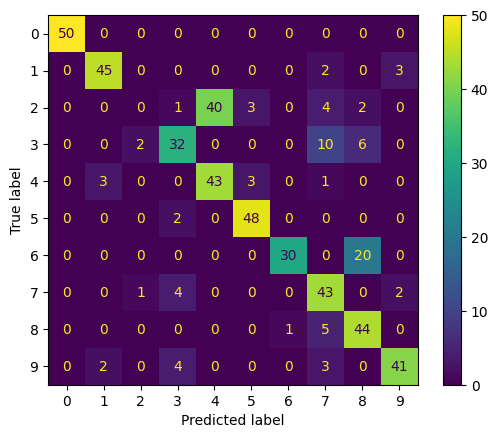

jackson


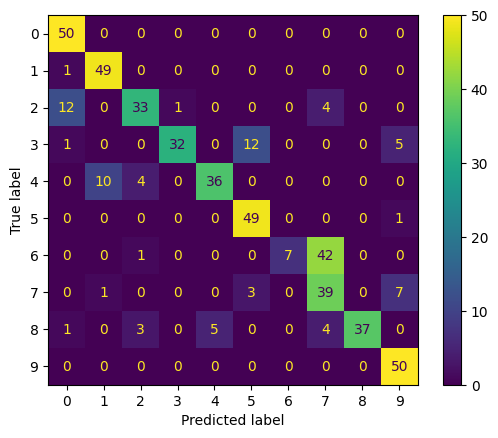

lucas


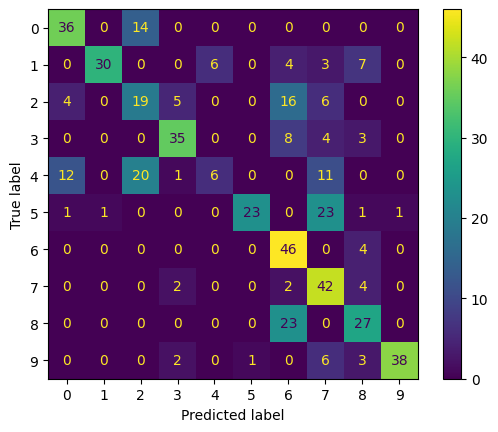

nicolas


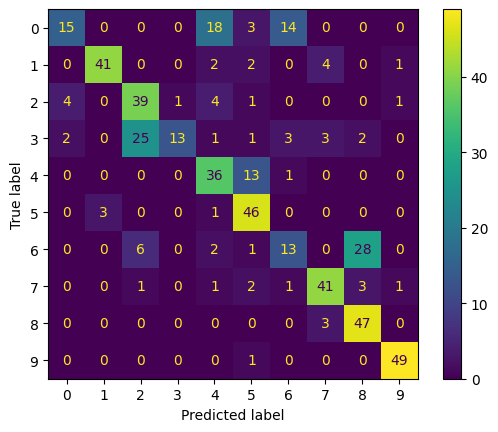

theo


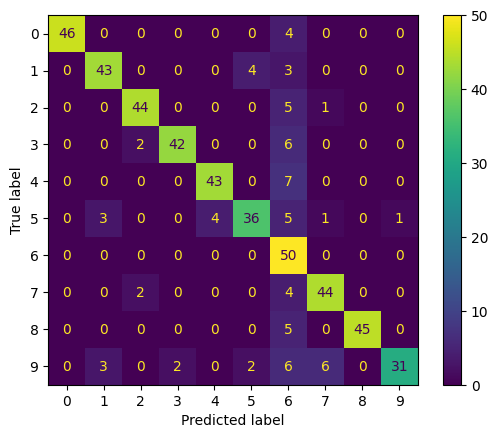

yweweler


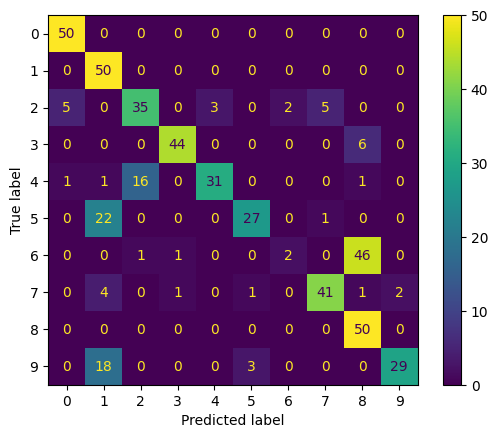

all speakers


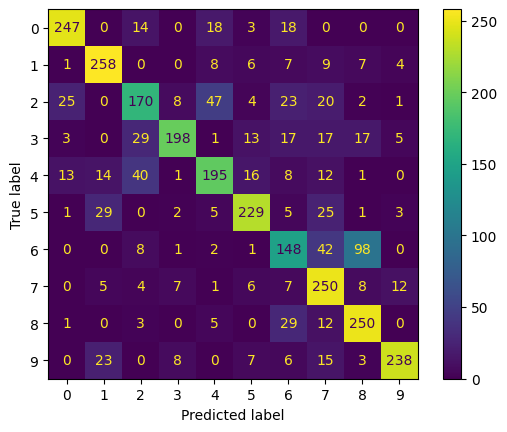

In [84]:
### TODO: 
### 1. based on the results, compute and display the confusion matrix for 
###    each test speaker 
### 2. compute and display the confusion matrix for the overall dataset

### YOUR CODE HERE

from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# confusion matrix for each speaker
for speaker in SPEAKERS:
    df_speaker = eval_df[eval_df['speaker'] == speaker]
    y_true = df_speaker["y_true"].to_list()
    y_pred = df_speaker["y_pred"].to_list()
    conf_mat = confusion_matrix(y_true, y_pred)
    # Visulasation
    print(speaker)
    vis = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    vis.plot()
    plt.show()

# confusion matrix for all
conf_mat = confusion_matrix(eval_df["y_true"].to_list(), eval_df["y_pred"].to_list())
print("all speakers")
vis = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
vis.plot()
plt.show()

### END YOUR CODE

---

## Task 2) Decoding Sequences of Digits

The example above can't handle sequences of spoken digits.
In this part of the assignment, you'll build a basic decoder that is able to decode arbitrary sequences of digits (without a prior, though).
The `decode` method in `hmmlearn` only works for a single HMM.
There are two ways how to solve this assignment:

- Construct a "meta" HMM from the previously trained digit HMMs, by allowing state transitions from one digit to another; the resulting HMM can be decoded using the existing `decode` method (don't forget to re-map the state ids to the originating digit).

- (Optional) Implement a real (time-synchronous) decoder using beam search. The straight-forward way is to maintain a (sorted) list of active hypotheses (ie. state history and current log-likelihood) that is first expanded and then pruned in each time step. The tricky part is at the "end" of a model: do you loop or expand new words?

---

### Generate Test Sequences

3.1 Generate a few test sequences of random length in between 3 and 6 digits; use [`numpy.random.randint`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html) and be sure to also retain the digits sequence since we need to compute edit distance between reference and hypotheses later.

In [25]:
def create_digit_sequence(speaker_dataframe, min_digits, max_digits):
    """
    Creates a sequence of spoken digits from a speaker and returns the
    features and reference label.
    """
    ### YOUR CODE HERE
    amount_digits = np.random.randint(min_digits, max_digits)
    data_seq = []
    digits = 0

    for i in range(0, amount_digits):
        seq = speaker_dataframe.sample()
        digits += seq.iloc[0]['digit'] * 10**(amount_digits-1 - i)
        data_seq.append(seq.iloc[0]['features'])

    return data_seq, digits
    raise NotImplementedError()
    
    ### END YOUR CODE

In [26]:
### Notice: just for test purposes

speaker = "george"
data_george = dataframe[dataframe["speaker"] == speaker]
for i in range(20):
    data_seq, digits = create_digit_sequence(data_george, 3, 6)
    print("Digits: {}".format(digits))

Digits: 55
Digits: 684
Digits: 2524
Digits: 29827
Digits: 426403
Digits: 399264
Digits: 560
Digits: 28006
Digits: 346
Digits: 14112
Digits: 512
Digits: 59018
Digits: 1628
Digits: 863001
Digits: 6589
Digits: 6159
Digits: 47976
Digits: 229
Digits: 3656
Digits: 3897


### Create "meta" HMM

4.1 Combine the previously trained HMMs to a single "meta" HMM, altering the transition probabilities to make a circular graph that allows each word to follow another.

4.2 Implement a method that converts a state sequence relating to the meta HMM into a sequence of actual digits.

4.3 Decode your test sequences and compute the [word error rate](https://en.wikipedia.org/wiki/Word_error_rate) (WER) with [JiWER](https://pypi.org/project/jiwer/) (install the package in your working environment).

4.4 Compute an overall WER; ie. over the cross-validation.

4.5 (Optional) Implement a basic time-synchronous beam search; how do the results compare to the above viterbi decoding in terms of accuracy and time?

In [ ]:
### YOUR CODE HERE



### END YOUR CODE

: 